# Draft

In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import datetime as dt

jtplot.style(figsize=(15, 9))

In [2]:
tickers = ['GLD', 'GDX', 'AAPL', 'SPY']
d_start = dt.datetime(2010, 1, 1)
d_final = dt.datetime(2020, 12, 31)

In [3]:
# df = yf.download(tickers, period='2y', interval='1h', auto_adjust=True)
# df.head()

In [4]:
df = pd.read_csv('../../../data/bt/gld_gdx_aapl_spy__1H.csv', parse_dates=True, header=[0, 1], index_col=0)
df.head()

Close                                     \
                                 AAPL        GDX         GLD         SPY   
Datetime                                                                   
2022-10-07 14:30:00-04:00  139.721893  24.440001  157.720001  361.619995   
2022-10-07 15:30:00-04:00  140.080002  24.420000  157.919998  362.799988   
2022-10-10 09:30:00-04:00  140.050003  24.250000  155.869995  362.489990   
2022-10-10 10:30:00-04:00  140.020004  24.195000  155.419998  360.339996   
2022-10-10 11:30:00-04:00  139.747498  24.190001  155.265106  359.050110   

                                 High                                     \
                                 AAPL        GDX         GLD         SPY   
Datetime                                                                   
2022-10-07 14:30:00-04:00  140.535004  24.750000  158.240005  363.500000   
2022-10-07 15:30:00-04:00  140.490005  24.570000  158.000000  363.260010   
2022-10-10 09:30:00-04:00  140.490005  24.549999  156.350006  364.170013   
2022-10-10 10:30:00-04:00  140.315002  24.410000  156.210007  362.660004   
2022-10-10 11:30:00-04:00  140.820007  24.350000  155.470001  361.470001   

                                  Low                                     \
                                 AAPL        GDX         GLD         SPY   
Datetime                                                                   
2022-10-07 14:30:00-04:00  139.600006  24.420200  157.690002  361.309998   
2022-10-07 15:30:00-04:00  139.445007  24.389999  157.679993  360.940002   
2022-10-10 09:30:00-04:00  138.572906  23.920000  155.714996  360.954987   
2022-10-10 10:30:00-04:00  139.100006  24.020000  155.119995  359.299988   
2022-10-10 11:30:00-04:00  139.649994  24.135000  155.184998  358.880005   

                                 Open                                     \
                                 AAPL        GDX         GLD         SPY   
Datetime                                                                   
2022-10-07 14:30:00-04:00  140.070007  24.722000  158.169998  362.660004   
2022-10-07 15:30:00-04:00  139.720001  24.440001  157.720001  361.619995   
2022-10-10 09:30:00-04:00  140.339996  23.980000  155.940002  364.000000   
2022-10-10 10:30:00-04:00  140.043304  24.250000  155.830002  362.510010   
2022-10-10 11:30:00-04:00  140.020004  24.195000  155.410004  360.350006   

                             Volume                                
                               AAPL      GDX        GLD       SPY  
Datetime                                                           
2022-10-07 14:30:00-04:00         0        0        0.0         0  
2022-10-07 15:30:00-04:00  13306374  5313055   777805.0  22447164  
2022-10-10 09:30:00-04:00  18501975  4979738  1454668.0  13559716  
2022-10-10 10:30:00-04:00   9885158  3489111  1179709.0  10581240  
2022-10-10 11:30:00-04:00   7226056  1816280   599102.0   7130794

## SMA

In [5]:
data = pd.DataFrame(df['Close']['GDX'])
data.rename(columns={'GDX': 'price'}, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3492 entries, 2022-10-07 14:30:00-04:00 to 2024-10-07 14:30:00-04:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   3492 non-null   float64
dtypes: float64(1)
memory usage: 40.9+ KB


<AxesSubplot:xlabel='Datetime'>

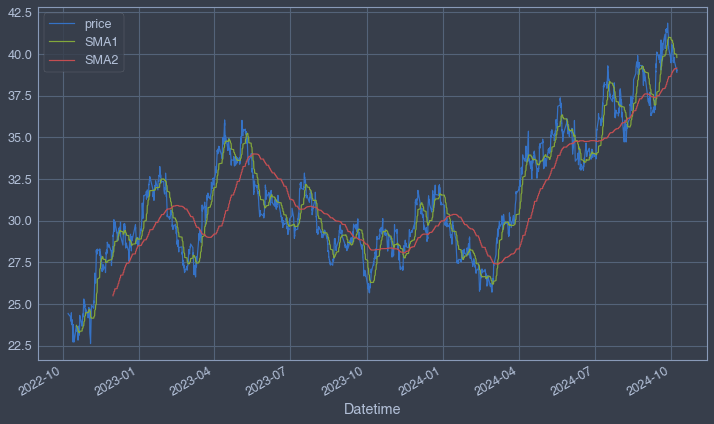

In [9]:
data['SMA1'] = data['price'].rolling(42).mean()
data['SMA2'] = data['price'].rolling(252).mean()

data.plot()

In [10]:
data.dropna(inplace=True)

In [11]:
data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
data['returns'] = np.log(data['price'] / data['price'].shift(1))

data['strategy'] = data['position'].shift(1) * data['returns']

In [16]:
data[['strategy', 'returns']].sum().apply(np.exp)

strategy    0.636642
returns     1.367311
dtype: float64

<AxesSubplot:>

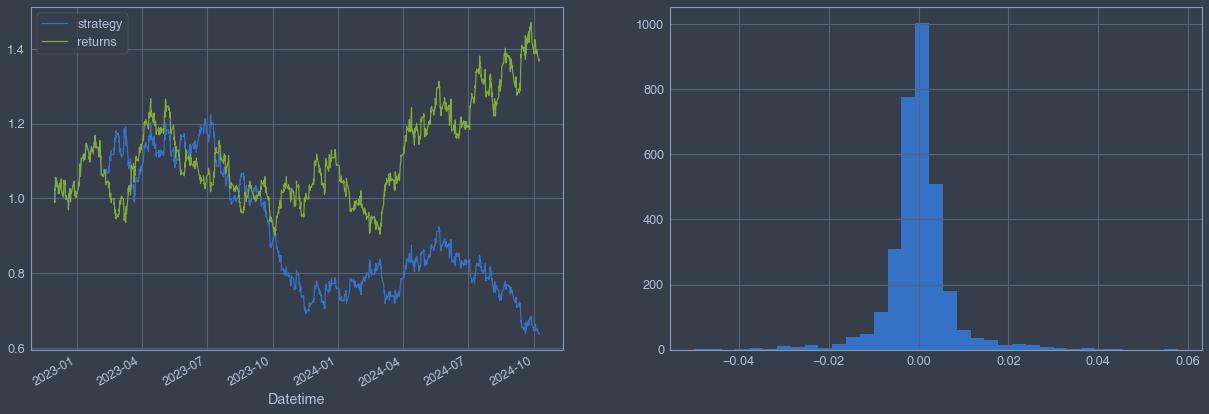

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(21, 7))
data[['strategy', 'returns']].cumsum().apply(np.exp).plot(ax=ax[0])
data['returns'].hist(bins=35, ax=ax[1])

In [48]:
def sma(sma1=[42], sma2=[252], d=data):
    d['returns'] = np.log(d['price'] / d['price'].shift(1))
    strategy = []
    for s1, s2 in zip(sma1, sma2):
        d[f'SMA1_{s1}'] = d['price'].rolling(s1).mean()
        d[f'SMA2_{s2}'] = d['price'].rolling(s2).mean()
        d.dropna(inplace=True)
        d[f'position_{s1}_{s2}'] = np.where(d[f'SMA1_{s1}'] > d[f'SMA2_{s2}'], 1, -1)
        d[f'strategy_{s1}_{s2}'] = d[f'position_{s1}_{s2}'].shift(1) * d['returns']
        strategy.append(f'strategy_{s1}_{s2}')
        
    ax = d[strategy+['returns']].cumsum().apply(np.exp).plot()
    print(d[strategy+['returns']].sum().apply(np.exp))
        

strategy_42_252    1.205247
strategy_24_180    1.183577
strategy_18_64     1.315175
strategy_6_22      1.026587
returns            1.422543
dtype: float64


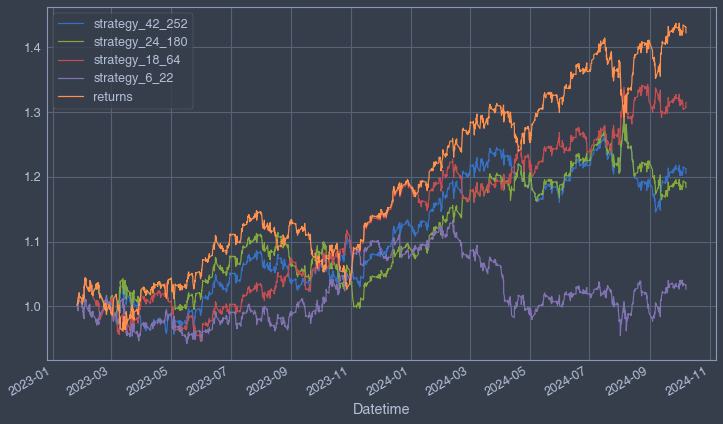

In [52]:
sma(sma1=[42, 24, 18, 6], sma2=[252, 180, 64, 22], d=pd.DataFrame(df['Close']['SPY']).rename(columns={'SPY': 'price'}))

## Class

In [ ]:
DATA_STORAGE = '../../../data'
class SMAVectorBacktester():
    def __init__(self, SMA1, SMA2, data_info):
#         self.symbol = symbol
#         self.start = start
#         self.end = end
#         self.interval = interval
        self.data_info = data_info
        self.data = None
        
        self.SMA1 = SMA1
        self.SMA2 = SMA2
        
        self.results = None
        
        self.get_data()
    
    def get_data(self):
        self.data_prepare()

        self.data = self.data['Close'].to_frame()
        self.data.rename(columns={'Close': 'price'}, inplace=True)
        
        self.data['return'] = np.log(data['price'] / data['price'].shift(1))
    
    def get_data_from_yf(self):
        self.data = yf.download(
            data['symbol'],
            start=data['start'],
            end=data['end'],
            interval=data['interval'],
            
            auto_adjust=True,
            progress=False,
            show_errors=True
        )
    
    def get_data_from_csv(self):
        f = f'{DATA_STORAGE}/{self.data_info}'
        if os.path.isfile(f):
            self.data = pd.read_csv(f'{f}', index_col=0, parse_dates=True)
        
    def data_prepare(self):
        if type(self.data_info) is str and self.data_info[-3:]=='csv':
            self.get_data_from_csv()
    
    def run_strategy(self):
        data = self.data.copy().dropna()
        
        data['SMA1'] = data['price'].rolling(self.SMA1).mean()
        data['SMA2'] = data['price'].rolling(self.SMA2).mean()
        
        data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
        data['strategy'] = data['position'].shift(1) * data['return']
        
        data.dropna(inplace=True)
        
        data['c_returns'] = data['return'].cumsum().apply(np.exp)
        data['c_strategy'] = data['strategy'].cumsum().apply(np.exp)
        
        self.results = data
        
        # gross performance
        aperf = data['c_strategy'].iloc[-1]
        # out / underperformance
        operf = aperf - data['c_returns'].iloc[-1]
        
        return round(aperf, 2), round(operf, 2)
